<a href="https://colab.research.google.com/github/victorjusa/Quantum_algorithms/blob/main/IBMQUANTUM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalando librerias e importandolas

In [ ]:
!pip install qiskit
!pip install setuptools
!pip install qiskit-ibm-runtime
!pip install qiskit-machine-learning
!pip install "requests~=2.27"
!pip install matplotlib
!pip install qiskit_ibm_provider
!pip install pip install pylatexenc
!pip install qiskit_aer

In [ ]:
# Create circuit to test transpiler on
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, Diagonal
# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import qiskit
from qiskit import QuantumCircuit
from qiskit_ibm_provider import least_busy
# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService,Session ,Batch,Session, Sampler
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler
import numpy as np
import math
from fractions import Fraction
import time


<ipython-input-2-3918914a112a>:9: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import least_busy


#Accediendo al servidor y creando un circuito basico

In [ ]:
# Creamos el canal con IMB Quantum
QiskitRuntimeService.save_account(channel="ibm_quantum", token='a53e5379fb809070499f1c93bc3e4c8f0f0d79ce82208e955f66a2c31c7a8e94dd89d9cbc9949876ae3df523d355ede6e607911af787b5049bbd56867feb8c2b', overwrite=True)

In [ ]:
#Creamos una variable de la clase QiskitRuntimeService para poder acceder a los servidores
provider=QiskitRuntimeService()

In [ ]:
#Tambien podemos filtrar para ver aquellos que solo tienen mas de x qubtis
provider.backends(min_num_qubits=5, simulator=False, operational=True)

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>]

In [ ]:
#Ahora vamos a elegir el servidor que este menos ocupado
small_devices = provider.backends(min_num_qubits=5, simulator=False, operational=True)
backend = least_busy(small_devices)
print(backend)

<IBMBackend('ibm_brisbane')>


In [ ]:
#Establecemos nuestro backend
backend = provider.get_backend('ibm_brisbane')

<ipython-input-7-9deb4e55609a>:2: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = provider.get_backend('ibm_brisbane')


In [ ]:
#Ahora creamos el circuito
circ = qiskit.QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

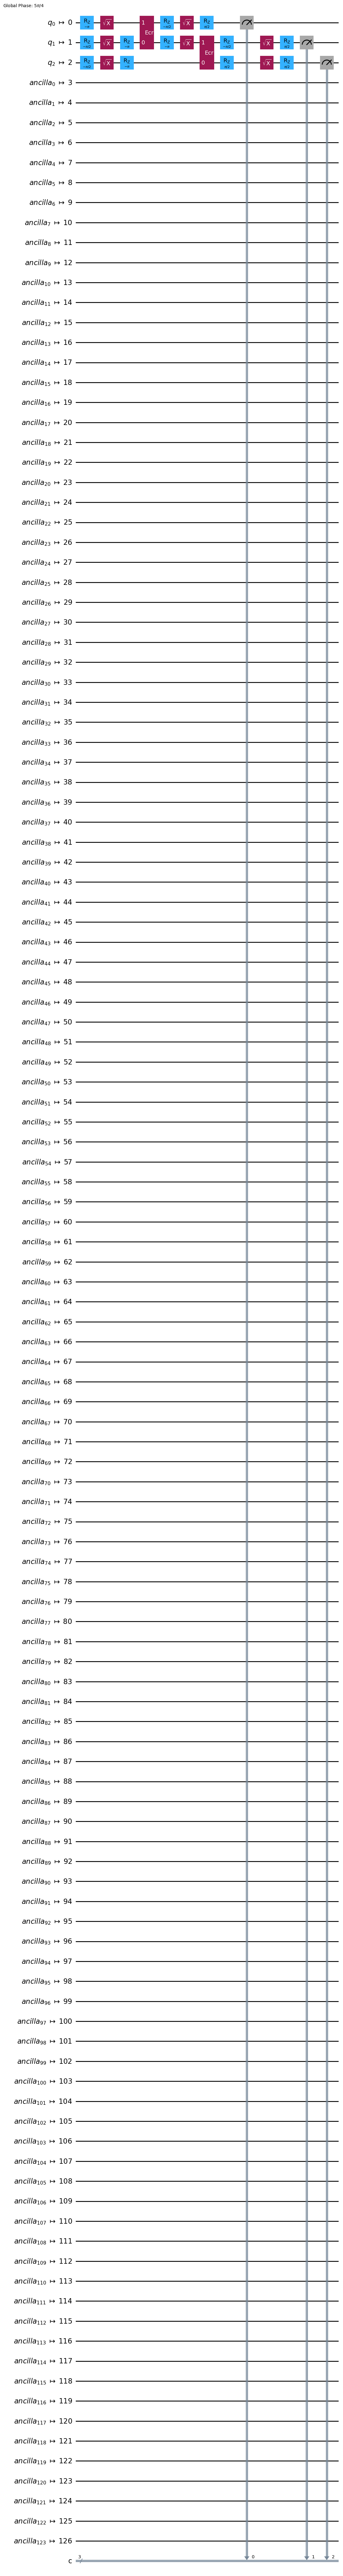

In [ ]:
#Tenemos que convertir el circuito para las puertas de nuestro
transpiled = transpile(circ, backend=backend)
transpiled.draw('mpl')

In [ ]:
#Podemos tambien ver cuales son las puertas logicas de las que dispone nuestro Backend
backend.basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

#Creando el algoritmo de Shor

In [ ]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4 + n_count, n_count)
    for q in range(n_count):
        qc.h(q)  # Initialize counting qubits in state |+>
    qc.x(3+n_count)  # And auxiliary register in state |1>
    for q in range(n_count):  # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+n_count for i in range(4)])
    # Do inverse-QFT to counting qubits
    qc.append(qft_dagger(n_count), range(n_count))
    qc.measure(range(n_count), range(n_count))
    return qc

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc = qc.to_gate()
    qc.name = "QFT†"
    return qc

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    U = QuantumCircuit(4)
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4,11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

def get_order(a):
    qc = qpe_amod15(a)
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=32)
    result = job.result()
    counts = result.get_counts(qc)
    counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
    # Get the value of s/r
    measured_phases = []
    for output in counts:
        decimal = int(output, 2)/2**8
        measured_phases.append(decimal)
    # Find r
    fractions = [Fraction(decimal).limit_denominator(15) for decimal in measured_phases]
    rs = [frac.denominator for frac in fractions]
    return rs[0]

def shor(N):
    np.random.seed(1) # To make the example repeatable
    a = np.random.randint(2, N)
    while math.gcd(a, N) != 1:
        a = np.random.randint(2, N)
    print(f"Random a chosen: {a}")
    r = get_order(a)
    print(f"Order found: {r}")
    if r % 2 != 0:
        return None
    if (a**(r//2) % N) == N-1:
        return None
    factor1 = math.gcd(a**(r//2)-1, N)
    factor2 = math.gcd(a**(r//2)+1, N)
    if factor1 == 1 or factor1 == N:
        return None
    return factor1, factor2


#Probando el algoritmo de Shor

Lo vamos a probar primero en modo simulacion

In [ ]:
# Factorizar el número 15
result = None
attempts = 0
while not result and attempts < 5:
    result = shor(15)
    attempts += 1
    if result:
        print(f"Los factores de 15 son: {result}")
    else:
        print("No se encontraron factores. Inténtalo de nuevo.")

In [ ]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token='a53e5379fb809070499f1c93bc3e4c8f0f0d79ce82208e955f66a2c31c7a8e94dd89d9cbc9949876ae3df523d355ede6e607911af787b5049bbd56867feb8c2b', overwrite=True)
provider = QiskitRuntimeService()

# Filtrar para ver aquellos que solo tienen más de x qubits
small_devices = provider.backends(min_num_qubits=5, simulator=False, operational=True)

# Elegir el servidor que esté menos ocupado
backend = least_busy(small_devices)
print(f"Elegido backend: {backend}")

# Establecemos nuestro backend
backend = provider.get_backend('ibm_brisbane')


# Crear el circuito cuántico
qc = qpe_amod15(7)
transpiled = transpile(qc, backend=backend)

# Ejecutar el circuito en el backend seleccionado usando BackendSampler
sampler = BackendSampler(backend)
job = sampler.run(transpiled)

Elegido backend: <IBMBackend('ibm_brisbane')>
Random a chosen: 7


<ipython-input-12-4491090c2ecc>:12: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = provider.get_backend('ibm_brisbane')


Order found: 4
Los factores de 15 son: (3, 5)
